# Facial Keypoints Detection

##### W207 Spring 2022 Section 10 
##### Team 4: Eric Sun, Jiayi Hu, Sridhar Chadalavada

### Introduction
We are using the Kaggle data set for [Facial Keypoints Detection](https://www.kaggle.com/c/facial-keypoints-detection/overview) to experiment and build models that detect the locations of up to 30 keypoints on images of faces. Facial keypoint detection in images has a variety of applications such as image tagging, biometrics, or psychological and clinical medical diagnosis.

The facial keypoints are primarily features dividing the face sagittally, for example the centers of the left and right eyes, with a smaller number of features in the midline, such as the tip of the nose. We will be exploring convolutional neural networks (CNNs) and the impacts of tuning parameters and hyperparameters to improve score and mitigate overfitting as well as comparing other models that may be less performant.

#### Data
The Kaggle data sets include labeled Training and unlabeled Testing data sets. Because we do not have access to the Test labels, the predicted Test labels of our final model will be scored within Kaggle, which will evaluate our submission against those of other participants based on the root mean square errors of the predicted and original values. Our Training data includes 7,049 images that we will use to divide into Training and Development sets, and our Test data includes 1,783 images. The images are represented as a grid of 96x96 pixels in the range of (0, 255) with each keypoint defined by an x and y position in that grid.

#### Internal Project Milestones
3/13: Baseline Submission  
3/20: Individual research and analysis into CNN modeling and transformation  
3/27: Identify chosen model parameters and experiments and merge for notebook report  
4/3: Complete final notebook  
4/10: Complete final presentation  
4/14: Final deliverable and in-class presentation  

### Initialization

In [1]:
import math
import numpy as np
import pandas as pd
from scipy import ndimage
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflowjs as tfjs

%matplotlib inline
pd.options.display.width = 800
rng = np.random.default_rng()

In [2]:
z = ZipFile('./facial-keypoints-detection.zip')
train_zip = ZipFile(z.open('training.zip'))
test_zip = ZipFile(z.open('test.zip'))

train = pd.read_csv(train_zip.open('training.csv'))
print('Initial Training', train.shape)

test = pd.read_csv(test_zip.open('test.csv'), index_col=0)
print('Initial Test', test.shape)

Initial Training (7049, 31)
Initial Test (1783, 1)


### Exploratory Data Analysis (EDA)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

Formatting Image Data

In [4]:
# Modify image data in-place

def format_string_into_list(target, from_col):
	target['image_data'] = target[from_col].map(lambda x: np.array([(int(y) if y != '' else 0) for y in x.split(' ')]))
	assert len(target['image_data'].map(len).unique()) == 1, f'Missing or uneven lengths in image data: {target.image_data.map(len)}' 
	assert min(target['image_data'].map(min)) >= 0, 'Negative values in image data'
	assert max(target['image_data'].map(max)) < 256, 'Unexpectedly large values in image data'

# Doing this first so we don't duplicate work
format_string_into_list(train, 'Image')

Dealing with Missing Values

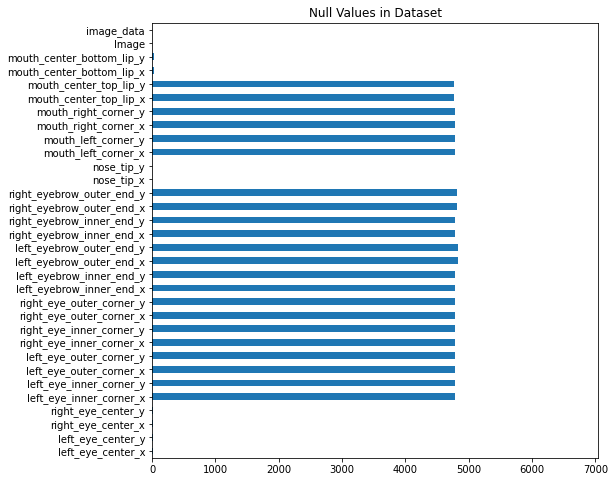

Original Dataset: (7049, 32)
Clean Dataset: (2140, 32)
Focused Dataset: (4860, 10)
Average Filled Dataset: (7049, 32)


In [5]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(111)

train.isnull().sum().plot(kind='barh')
plt.title('Null Values in Dataset')
plt.xlim(0, len(train))

plt.show()

train_avg = train.copy()
for col in train_avg.columns:
    if train_avg[col].isnull().sum() != 0:
        train_avg[col] = train_avg[col].fillna(np.mean(train_avg[col]))

train_no_na = train.dropna(axis=0)
train_less_features = train.loc[~train.index.isin(train_no_na.index), [
	'left_eye_center_x', 'left_eye_center_y', 
	'right_eye_center_x', 'right_eye_center_y',
	'nose_tip_x', 'nose_tip_y',
	'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
	'Image', 'image_data',
]].dropna(axis=0).copy().reset_index(drop=True)
train_no_na = train_no_na.copy().reset_index(drop=True)

print('Original Dataset:', train.shape)
print('Clean Dataset:', train_no_na.shape)
print('Focused Dataset:', train_less_features.shape)
print('Average Filled Dataset:', train_avg.shape)

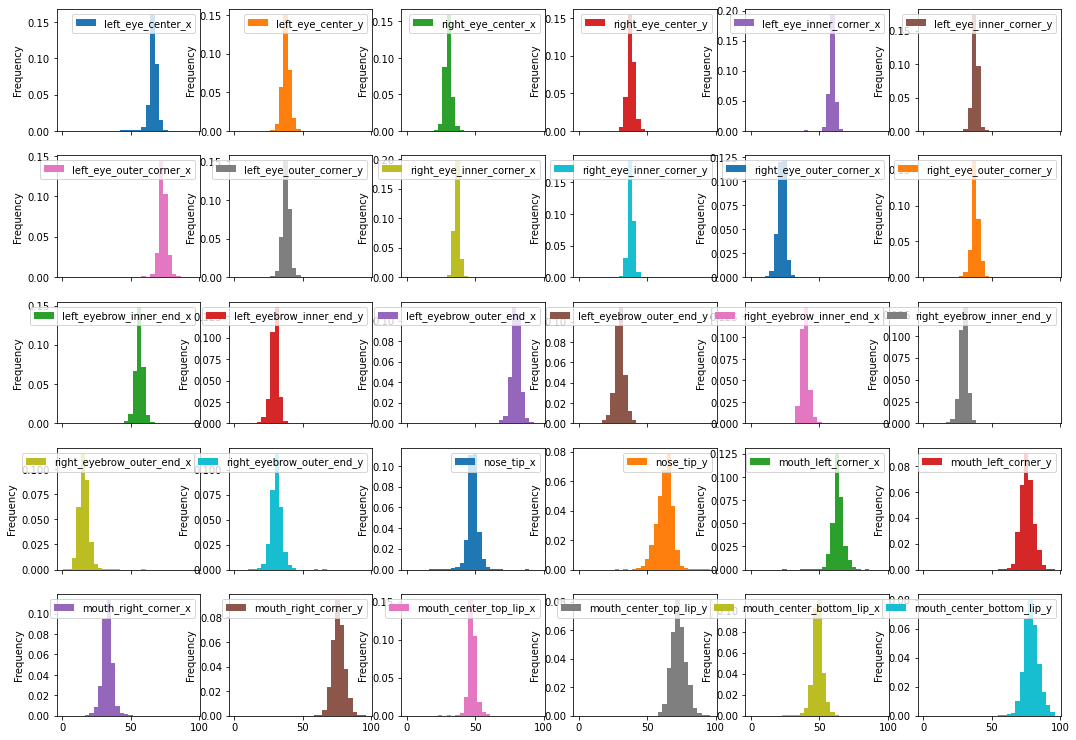

In [6]:
train.iloc[:, :-1].plot(kind='hist',subplots=True, layout=(5, 6), figsize=(18,13), bins=30,density=True)
plt.show()

Image Preview

Clean Dataset with all features


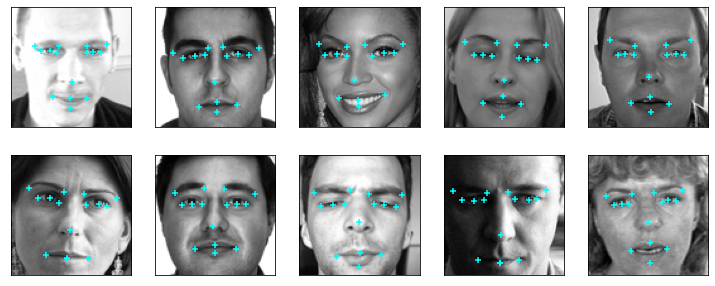

Focused Dataset


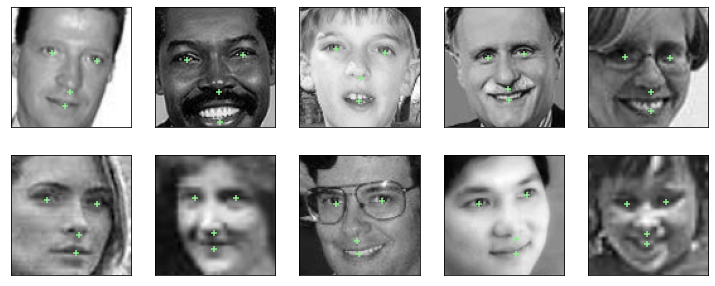

Averaged Dataset


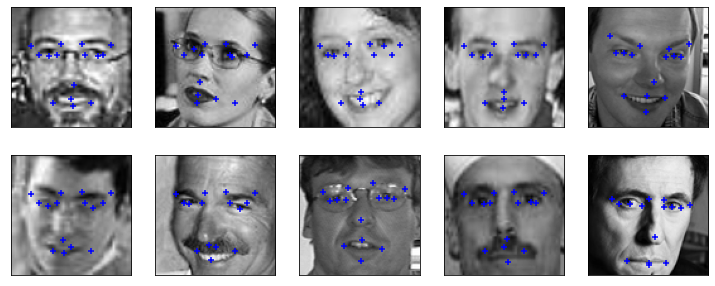

In [7]:
def show_faces(target, height, width, color='lightgreen', additional_points=None, color2='red'):
	random_indexes = rng.choice(target.index, width * height, False)
	fig = plt.figure(figsize=(width * 2.5, height * 2.5))
	for i in range(width * height):
		fig.add_subplot(height, width, i + 1)
		plt.imshow(target.at[random_indexes[i], 'image_data'].reshape(96, 96), cmap='gray')
		keypoints = target.iloc[random_indexes[i], :~1].to_numpy()
		plt.scatter(keypoints[0::2], keypoints[1::2], c=color, marker='+')
		if isinstance(additional_points, np.ndarray):
			plt.scatter(additional_points[random_indexes[i]][0::2], additional_points[random_indexes[i]][1::2], c=color2, marker='x')
		plt.xticks([])
		plt.yticks([])
	plt.show()

print('Clean Dataset with all features')
show_faces(train_no_na, 2, 5, 'cyan')
print('Focused Dataset')
show_faces(train_less_features, 2, 5, 'lightgreen')
print('Averaged Dataset')
show_faces(train_avg, 2, 5, 'blue')

Withhold Test Data then Add Variations

Rotated Faces


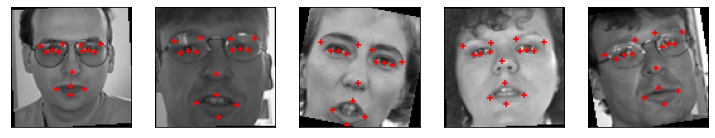

Shifted Faces


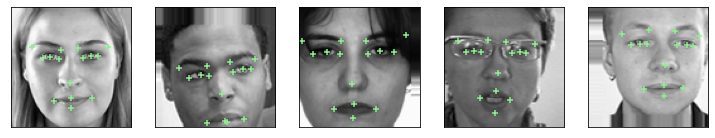

Flipped Faces


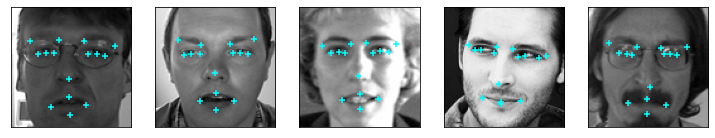

Squeezed Faces


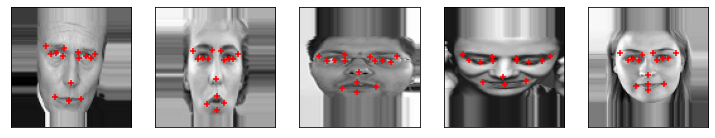

Over/Underexposed Faces


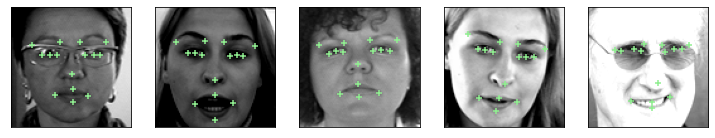

Original Dataset Size: (2140, 32)
Enhanced Dataset Size: (4280, 32)
Original Averaged Dataset Size: (7049, 32)
Enhanced Averaged Dataset Size: (9185, 32)


In [8]:
def add_variations(source, amount_remixed, show):
	rotated_train = source.iloc[rng.choice(source.index, amount_remixed, False), :].copy().reset_index(drop=True)
	shifted_train = source.iloc[rng.choice(source.index, amount_remixed, False), :].copy().reset_index(drop=True)
	flipped_train = source.iloc[rng.choice(source.index, amount_remixed, False), :].copy().reset_index(drop=True)
	squeeze_train = source.iloc[rng.choice(source.index, amount_remixed, False), :].copy().reset_index(drop=True)
	bwshift_train = source.iloc[rng.choice(source.index, amount_remixed, False), :].copy().reset_index(drop=True)

	def rotate_sample(x):
		radians = -math.radians(x.rotation)
		for i in range(0, 30, 2):
			p_x, p_y = x[i] - 48, x[i + 1] - 48
			x[i] 			= p_x * math.cos(radians) - p_y * math.sin(radians) + 48
			x[i + 1] 	= p_x * math.sin(radians) + p_y * math.cos(radians) + 48
		x.image_data = ndimage.rotate(x.image_data.reshape(96, 96), x.rotation, reshape=False).flatten()
		return x

	def shift_sample(x):
		xmin, xmax = min(x[0:-4:2]), 96 - max(x[0:-4:2])
		ymin, ymax = min(x[1:-4:2]), 96 - max(x[1:-4:2])
		x.shift_x = x.shift_x * (xmax + xmin) - xmin
		x.shift_y = x.shift_y * (ymax + ymin) - ymin
		for i in range(0, 30, 2):
			x[i] += x.shift_x 
			x[i + 1] += x.shift_y
		x.image_data = ndimage.shift(x.image_data.reshape(96, 96), [x.shift_y, x.shift_x], mode='nearest').flatten()
		return x

	def flip_sample(x):
		for i in range(0, 30, 2):
			x[i] = 96 - x[i]
		x.left_eye_center_x, x.right_eye_center_x = x.right_eye_center_x, x.left_eye_center_x
		x.left_eye_center_y, x.right_eye_center_y = x.right_eye_center_y, x.left_eye_center_y
		x.left_eye_inner_corner_x, x.right_eye_inner_corner_x = x.right_eye_inner_corner_x, x.left_eye_inner_corner_x
		x.left_eye_inner_corner_y, x.right_eye_inner_corner_y = x.right_eye_inner_corner_y, x.left_eye_inner_corner_y
		x.left_eye_outer_corner_x, x.right_eye_outer_corner_x = x.right_eye_outer_corner_x, x.left_eye_outer_corner_x
		x.left_eye_outer_corner_y, x.right_eye_outer_corner_y = x.right_eye_outer_corner_y, x.left_eye_outer_corner_y
		x.left_eyebrow_inner_end_x, x.right_eyebrow_inner_end_x = x.right_eyebrow_inner_end_x, x.left_eyebrow_inner_end_x
		x.left_eyebrow_inner_end_y, x.right_eyebrow_inner_end_y = x.right_eyebrow_inner_end_y, x.left_eyebrow_inner_end_y
		x.left_eyebrow_outer_end_x, x.right_eyebrow_outer_end_x = x.right_eyebrow_outer_end_x, x.left_eyebrow_outer_end_x
		x.left_eyebrow_outer_end_y, x.right_eyebrow_outer_end_y = x.right_eyebrow_outer_end_y, x.left_eyebrow_outer_end_y
		x.mouth_left_corner_x, x.mouth_right_corner_x = x.mouth_right_corner_x, x.mouth_left_corner_x
		x.mouth_left_corner_y, x.mouth_right_corner_y = x.mouth_right_corner_y, x.mouth_left_corner_y
		x.image_data = np.flip(x.image_data.reshape(96, 96), axis=1).flatten()
		return x

	def squeeze_sample(x):

		def shift_function(c):
			return ((c[0] - 48) * squeeze_x + 48, ((c[1] - 48)) * squeeze_y + 48)

		squeeze_x = 1 / x.squeeze_y
		squeeze_y = 1 / x.squeeze_x

		for i in range(0, 30, 2):
			x[i], x[i + 1] = shift_function((x[i], x[i + 1]))

		squeeze_x = x.squeeze_x
		squeeze_y = x.squeeze_y

		x.image_data = ndimage.geometric_transform(x.image_data.reshape(96, 96), shift_function, mode='nearest').flatten()
		return x

	def bwshift_sample(x):
		x.image_data = np.clip(x.image_data + x.brightness, 0, 255).astype(np.uint8)
		return x

	rotated_train['rotation'] = (rng.random(amount_remixed) - 0.5) * 30
	shifted_train['shift_x'] = rng.random(amount_remixed) * 0.90 + 0.05
	shifted_train['shift_y'] = rng.random(amount_remixed) * 0.90 + 0.05
	squeeze_train['squeeze_x'] = rng.random(amount_remixed) * 1 + 1
	squeeze_train['squeeze_y'] = 3 - squeeze_train['squeeze_x']
	bwshift_train['brightness'] = rng.choice([-1, 1], amount_remixed) * (rng.random(amount_remixed) * 0.20 + 0.20) * 255

	rotated_train = rotated_train.apply(rotate_sample, axis=1).iloc[:, :-1]
	shifted_train = shifted_train.apply(shift_sample, axis=1).iloc[:, :-2]
	flipped_train = flipped_train.apply(flip_sample, axis=1)
	squeeze_train = squeeze_train.apply(squeeze_sample, axis=1).iloc[:, :-2]
	bwshift_train = bwshift_train.apply(bwshift_sample, axis=1).iloc[:, :-1]

	if show:
		print('Rotated Faces')
		show_faces(rotated_train, 1, 5, 'red')

		print('Shifted Faces')
		show_faces(shifted_train, 1, 5, 'lightgreen')

		print('Flipped Faces')
		show_faces(flipped_train, 1, 5, 'cyan')

		print('Squeezed Faces')
		show_faces(squeeze_train, 1, 5, 'red')

		print('Over/Underexposed Faces')
		show_faces(bwshift_train, 1, 5, 'lightgreen')

	return pd.concat([train_no_na, rotated_train, shifted_train, flipped_train, squeeze_train, bwshift_train], ignore_index=True)

enhanced_train_no_na = add_variations(train_no_na, len(train_no_na) // 5, True)
enhanced_train_avg = add_variations(train_avg, len(train_avg) // 5, False)

print('Original Dataset Size:', train_no_na.shape)
print('Enhanced Dataset Size:', enhanced_train_no_na.shape)

print('Original Averaged Dataset Size:', train_avg.shape)
print('Enhanced Averaged Dataset Size:', enhanced_train_avg.shape)

Vectorizing Data

In [9]:
x1 = np.concatenate(enhanced_train_no_na.image_data.to_numpy()).reshape(-1, 96, 96, 1)
y1 = np.concatenate(enhanced_train_no_na.iloc[:,:~1].to_numpy()).reshape(-1, len(enhanced_train_no_na.columns) - 2)
print('Clean Train data shape:', x1.shape, 'Label shape:', y1.shape)

x1_ = np.concatenate(enhanced_train_avg.image_data.to_numpy()).reshape(-1, 96, 96, 1)
y1_ = np.concatenate(enhanced_train_avg.iloc[:,:~1].to_numpy()).reshape(-1, len(enhanced_train_avg.columns) - 2)
print('Averaged Train data shape:', x1_.shape, 'Label shape:', y1_.shape)

Clean Train data shape: (4280, 96, 96, 1) Label shape: (4280, 30)
Averaged Train data shape: (9185, 96, 96, 1) Label shape: (9185, 30)


### Model Building

Configuring model
https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

Video introductions to CNNs (recommend watching these on 2x speed):
- 3Blue1Brown Neural Networks Playlist - https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
- "How Convolutional Neural Networks work", by Brandon Roher - https://youtu.be/FmpDIaiMIeA

Learning material on topics
- Batch Normalization - https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/
- ReLU - https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/

Good starting point for building a full model / hyperparameter tuning:
- https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7

Hyperparameters:
- Convolution:
	- Number of Features
	- Size of Features
- Pooling:
	- Window Size
	- Window Stride
- Fully Connected:
	- Number of Neurons
- Architecture:
	- How many of each type of layer
	- In what order

Model 1

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d (Conv2D)                             (None, 94, 94, 32)                      320            
                                                                                                    
 max_pooling2d (MaxPooling2D)                (None, 47, 47, 32)                      0              
                                                                                                    
 conv2d_1 (Conv2D)                           (None, 45, 45, 16)                      4624           
                                                                                                    
 max_pooling2d_1 (MaxPooling2D)              (None, 22, 22, 16)                      0              
                                                                       

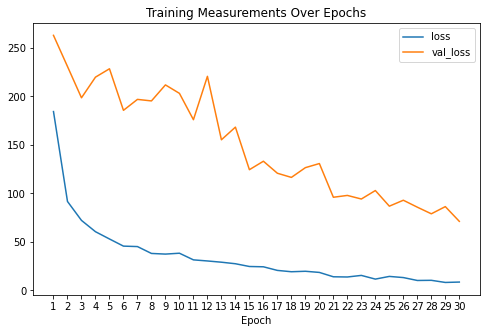

In [10]:
model_1a = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(96, 96, 1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation='linear')
])
model_1a.summary(line_length=100)
model_1a.compile(optimizer='adam', loss='mse')

h = model_1a.fit(x1, y1, batch_size=32, epochs=30, validation_split=0.1)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for item in h.history:
	ax.plot(h.history[item], label=item)

ax.set_title('Training Measurements Over Epochs')
ax.set_xlabel('Epoch')
ax.set_xticks(range(30))
ax.set_xticklabels(range(1, 31))
ax.legend()
plt.show()

Model 2

Model: "sequential_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_2 (Conv2D)                           (None, 94, 94, 32)                      320            
                                                                                                    
 max_pooling2d_2 (MaxPooling2D)              (None, 47, 47, 32)                      0              
                                                                                                    
 dropout (Dropout)                           (None, 47, 47, 32)                      0              
                                                                                                    
 conv2d_3 (Conv2D)                           (None, 45, 45, 32)                      9248           
                                                                     

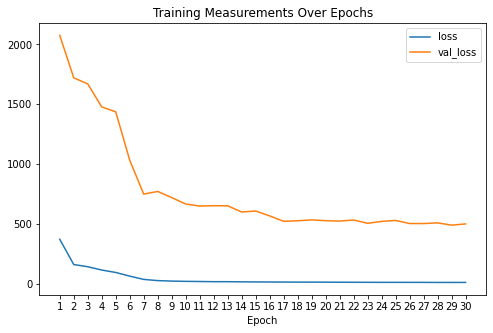

In [11]:
model_2a = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(96, 96, 1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation='linear')
])
model_2a.summary(line_length=100)
model_2a.compile(optimizer='adam', loss='mse')

h = model_2a.fit(x1, y1, batch_size=32, epochs=30, validation_split=0.1)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for item in h.history:
	ax.plot(h.history[item], label=item)

ax.set_title('Training Measurements Over Epochs')
ax.set_xlabel('Epoch')
ax.set_xticks(range(30))
ax.set_xticklabels(range(1, 31))
ax.legend()
plt.show()

Model 3

Model: "sequential_2"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_5 (Conv2D)                           (None, 94, 94, 32)                      320            
                                                                                                    
 max_pooling2d_5 (MaxPooling2D)              (None, 47, 47, 32)                      0              
                                                                                                    
 dropout_3 (Dropout)                         (None, 47, 47, 32)                      0              
                                                                                                    
 conv2d_6 (Conv2D)                           (None, 45, 45, 32)                      9248           
                                                                     

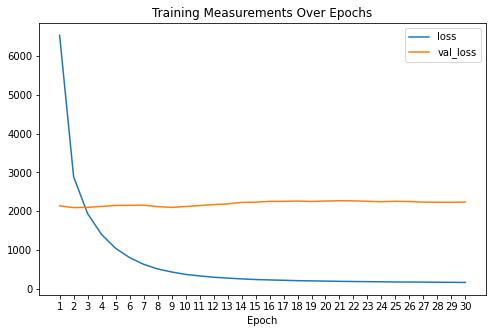

In [12]:
model_3a = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(96, 96, 1)),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(30, activation='linear')
])
model_3a.summary(line_length=100)
model_3a.compile(optimizer=tf.keras.optimizers.Adadelta(
    learning_rate=0.01
), loss='mse')

h = model_3a.fit(x1, y1, batch_size=32, epochs=30, validation_split=0.1)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for item in h.history:
	ax.plot(h.history[item], label=item)

ax.set_title('Training Measurements Over Epochs')
ax.set_xlabel('Epoch')
ax.set_xticks(range(30))
ax.set_xticklabels(range(1, 31))
ax.legend()
plt.show()

In [13]:
model4a = tf.keras.Sequential([

	# strides=1 and padding='same' -> output is same size as input
	tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', use_bias=False, input_shape=(96, 96, 1)),
	tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(pool_size=2),

	tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', use_bias=False),
	# tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(pool_size=2),

	tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', use_bias=False),
	# tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(pool_size=2),

	tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', use_bias=False),
	# tf.keras.layers.BatchNormalization(),
	tf.keras.layers.MaxPool2D(pool_size=2),

	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(256, activation='relu'),
	tf.keras.layers.Dropout(0.1),
	tf.keras.layers.Dense(30),
])

model4a.summary(line_length=100)

Model: "sequential_3"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv2d_8 (Conv2D)                           (None, 96, 96, 32)                      288            
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 96, 96, 32)                      128            
                                                                                                    
 max_pooling2d_8 (MaxPooling2D)              (None, 48, 48, 32)                      0              
                                                                                                    
 conv2d_9 (Conv2D)                           (None, 48, 48, 32)                      9216           
                                                                     

In [14]:
model4a.compile(optimizer='adam', loss='mse')
h = model4a.fit(x1, y1, epochs=10, validation_split=0.1)

Epoch 1/10
121/121 [==============================] - 61s 499ms/step - loss: 206.0243 - val_loss: 50.4819
Epoch 2/10
121/121 [==============================] - 57s 472ms/step - loss: 48.6931 - val_loss: 29.1114
Epoch 3/10
121/121 [==============================] - 59s 484ms/step - loss: 44.6810 - val_loss: 56.8258
Epoch 4/10
121/121 [==============================] - 58s 480ms/step - loss: 31.9192 - val_loss: 40.1833
Epoch 5/10
121/121 [==============================] - 97s 805ms/step - loss: 24.3231 - val_loss: 48.9205
Epoch 6/10
121/121 [==============================] - 62s 515ms/step - loss: 26.7828 - val_loss: 28.9644
Epoch 7/10
121/121 [==============================] - 60s 495ms/step - loss: 21.2556 - val_loss: 16.0736
Epoch 8/10
121/121 [==============================] - 60s 497ms/step - loss: 20.1745 - val_loss: 15.1665
Epoch 9/10
121/121 [==============================] - 63s 520ms/step - loss: 17.7480 - val_loss: 16.6332
Epoch 10/10
121/121 [==============================] -

Training History

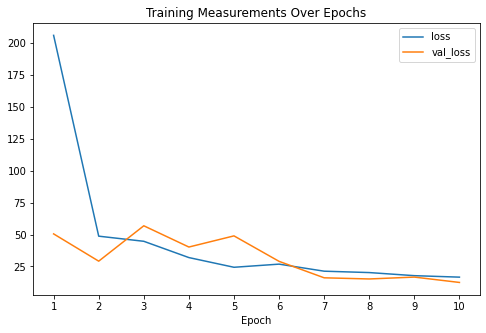

In [15]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for item in h.history:
	ax.plot(h.history[item], label=item)

ax.set_title('Training Measurements Over Epochs')
ax.set_xlabel('Epoch')
ax.set_xticks(range(10))
ax.set_xticklabels(range(1, 11))
ax.legend()
plt.show()

Evaluate Model

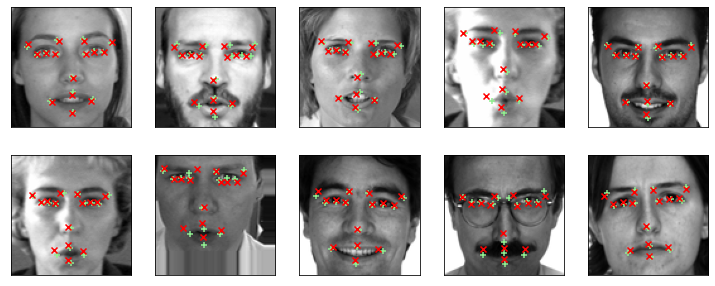

In [16]:
show_faces(enhanced_train_no_na, 2, 5, additional_points=model4a.predict(x1))

Predicting on Focused Dataset

In [17]:
x2 = np.concatenate(train_less_features.image_data.to_numpy()).reshape(-1, 96, 96, 1)
y2 = model4a.predict(x2)
print('Focused Train data shape:', x2.shape, 'Prediction shape:', y2.shape)

Focused Train data shape: (4860, 96, 96, 1) Prediction shape: (4860, 30)


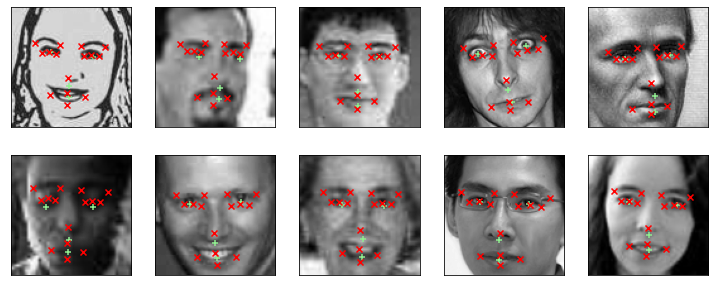

In [18]:
show_faces(train_less_features, 2, 5, additional_points=y2)

Calculate MSE for Focused Predictions

"Good" Predictions


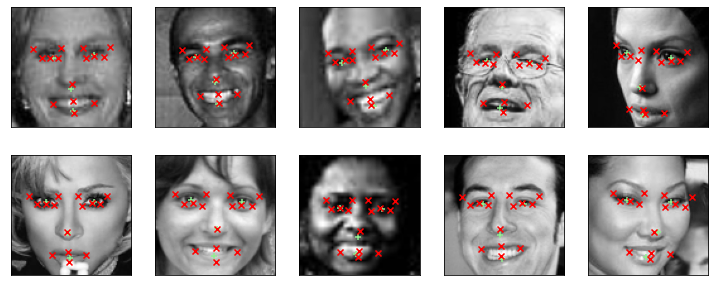

"Bad" Predictions


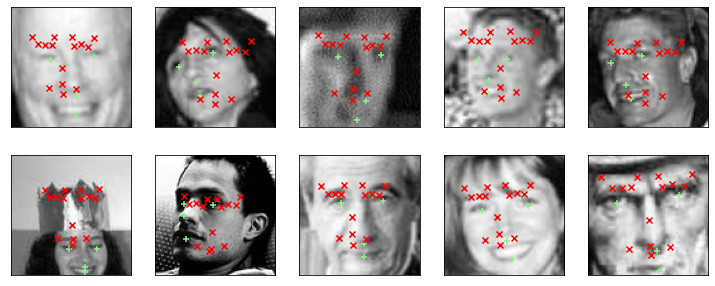

In [19]:
predicted_features = pd.DataFrame(y2, columns=train_no_na.columns[:-2])
p_rank = train_less_features.iloc[:, :-2].copy()

for c in p_rank.columns:
	p_rank[c] -= predicted_features[c]
p_rank = (p_rank.pow(2).sum(axis=1) / len(p_rank.columns)).sort_values()

print('"Good" Predictions')
show_faces(
	train_less_features.loc[train_less_features.index.isin(p_rank.index[:100]), :].reset_index(drop=True), 2, 5, 
	additional_points=predicted_features.loc[predicted_features.index.isin(p_rank.index[:100]), :].to_numpy()
)

print('"Bad" Predictions')
show_faces(
	train_less_features.loc[train_less_features.index.isin(p_rank.index[-100:]), :].reset_index(drop=True), 2, 5, 
	additional_points=predicted_features.loc[predicted_features.index.isin(p_rank.index[-100:]), :].to_numpy()
)

Recycling!

In [20]:
x3 = np.concatenate(train_less_features.loc[train_less_features.index.isin(p_rank.index[:500]), :].image_data.to_numpy()).reshape(-1, 96, 96, 1)
y3 = predicted_features.loc[predicted_features.index.isin(p_rank.index[:500]), :].to_numpy()
print('Focused Train data shape:', x3.shape, 'Prediction / Label shape:', y3.shape)

Focused Train data shape: (500, 96, 96, 1) Prediction / Label shape: (500, 30)


In [21]:
h = model4a.fit(x3, y3, epochs=2, validation_data=(x1, y1))

Epoch 1/2
16/16 [==============================] - 22s 1s/step - loss: 11.6424 - val_loss: 16.6128
Epoch 2/2
16/16 [==============================] - 23s 1s/step - loss: 14.7574 - val_loss: 20.1457


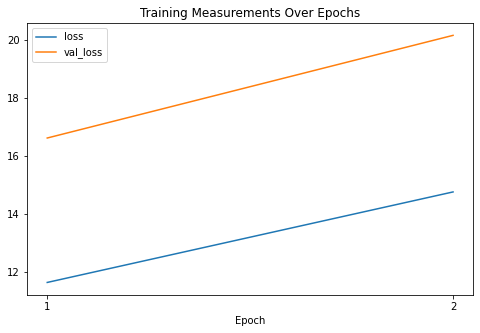

In [22]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for item in h.history:
	ax.plot(h.history[item], label=item)

ax.set_title('Training Measurements Over Epochs')
ax.set_xlabel('Epoch')
ax.set_xticks(range(2))
ax.set_xticklabels(range(1, 3))
ax.legend()
plt.show()

### Analysis of Predictions

In [23]:
format_string_into_list(test, 'Image')

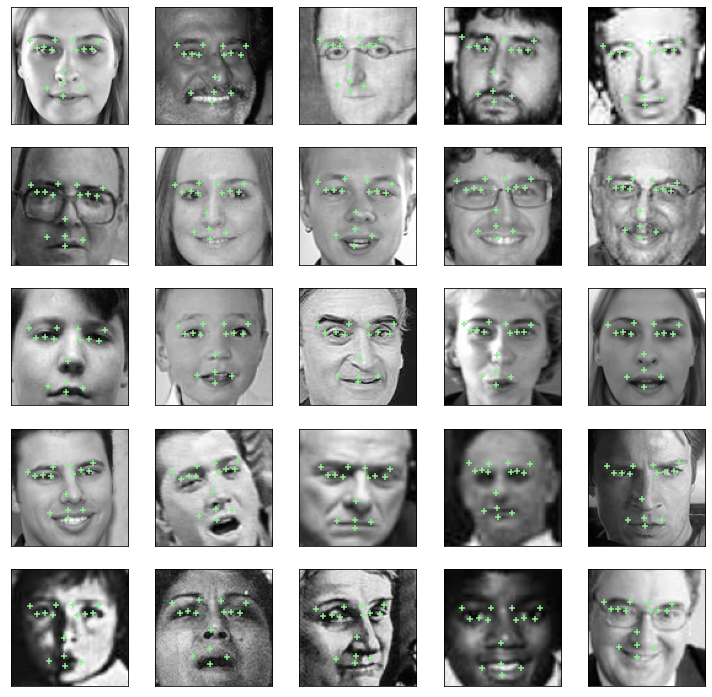

In [24]:
x = np.concatenate(test.image_data.to_numpy()).reshape(-1, 96, 96)
y = model4a.predict(x)
show_faces(pd.concat([pd.DataFrame(y), test.reset_index(drop=True)], axis=1), 5, 5)

### Export model into TFJS

In [25]:
tfjs.converters.save_keras_model(model4a, 'tfjs_model', weight_shard_size_bytes=999999999)